Packages

In [0]:
import pandas as pd
import numpy as np
import os
import datetime

import matplotlib.pyplot as plt
from skimage import color, exposure

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
cd 'drive/My Drive/Colab Notebooks/notebooks'

/content/drive/My Drive/Colab Notebooks/notebooks


Data

In [0]:
train = pd.read_pickle('../data/train.p')
test = pd.read_pickle('../data/test.p')
signnames = pd.read_csv('../data/signnames.csv')

In [0]:
xTrain, yTrain = train['features'], train['labels']
xTest, yTest = test['features'], test['labels']
labelsDict = signnames.to_dict()['b']

if yTrain.ndim == 1:
    yTrain = to_categorical(yTrain)
    
if yTest.ndim == 1:
    yTest = to_categorical(yTest)

Base parameters of model.

In [0]:
inputShape = xTrain.shape[1:]
numClasses = yTrain.shape[1]

Base model

In [0]:
model = Sequential([
    Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = inputShape),
    Flatten(),
    Dense(numClasses, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 43)                2476843   
Total params: 2,478,635
Trainable params: 2,478,635
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
model.fit(xTrain, yTrain)

1088/1088 [==============================] - 8s 7ms/step - loss: 8.1872 - accuracy: 0.8027


In [0]:
def getCNN_v1(aInputShape: list, aNumClasses: int) -> Sequential:
    return Sequential([
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = aInputShape),
        Flatten(),
        Dense(aNumClasses, activation = 'softmax')
    ])

def trainModel(aModel: Sequential, aXTrain, aYTrain, aParamsFit = {}):
    aModel.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    
    logdir = os.path.join('logs', datetime.datetime.now().strftime('%y%m%d-%H%M%S'))
    tensorboardCallback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)
    
    aModel.fit(
        aXTrain, 
        aYTrain,
        batch_size = aParamsFit.get('batch_size', 128),
        epochs = aParamsFit.get('epochs', 5),
        verbose = aParamsFit.get('verbose', 1),
        validation_data = aParamsFit.get('validation_data', (aXTrain, aYTrain)),
        callbacks = [tensorboardCallback])
    
    return model

In [0]:
model = getCNN_v1(inputShape, numClasses)
modelTrained = trainModel(model, xTrain, yTrain)

Epoch 1/5
272/272 [==============================] - 5s 17ms/step - loss: 23.5769 - accuracy: 0.7652 - val_loss: 0.2374 - val_accuracy: 0.9467
Epoch 2/5
272/272 [==============================] - 5s 17ms/step - loss: 0.2261 - accuracy: 0.9474 - val_loss: 0.1408 - val_accuracy: 0.9710
Epoch 3/5
272/272 [==============================] - 5s 17ms/step - loss: 0.1719 - accuracy: 0.9600 - val_loss: 0.2216 - val_accuracy: 0.9558
Epoch 4/5
272/272 [==============================] - 5s 17ms/step - loss: 0.1303 - accuracy: 0.9720 - val_loss: 0.0895 - val_accuracy: 0.9816
Epoch 5/5
272/272 [==============================] - 5s 17ms/step - loss: 0.0775 - accuracy: 0.9828 - val_loss: 0.0751 - val_accuracy: 0.9832


In [0]:
def predict(aTrainedModel, aXTest, aYTest, scoring = accuracy_score):
  yTestNorm = np.argmax(aYTest, axis = 1)

  yPredProb = aTrainedModel.predict(aXTest)
  yPred = np.argmax(yPredProb, axis = 1)

  return scoring(yTestNorm, yPred)

In [0]:
predict(modelTrained, xTest, yTest)

0.8251700680272109

In [0]:
model = getCNN_v1(inputShape, numClasses)
modelTrained = trainModel(model, xTrain, yTrain)
predict(modelTrained, xTest, yTest)

Epoch 1/5
272/272 [==============================] - 5s 17ms/step - loss: 34.0666 - accuracy: 0.7515 - val_loss: 0.2587 - val_accuracy: 0.9433
Epoch 2/5
272/272 [==============================] - 5s 17ms/step - loss: 0.2090 - accuracy: 0.9539 - val_loss: 0.1253 - val_accuracy: 0.9705
Epoch 3/5
272/272 [==============================] - 5s 17ms/step - loss: 0.1508 - accuracy: 0.9692 - val_loss: 0.1489 - val_accuracy: 0.9644
Epoch 4/5
272/272 [==============================] - 5s 17ms/step - loss: 0.1091 - accuracy: 0.9763 - val_loss: 0.0708 - val_accuracy: 0.9830
Epoch 5/5
272/272 [==============================] - 5s 17ms/step - loss: 0.0883 - accuracy: 0.9808 - val_loss: 0.0625 - val_accuracy: 0.9868


0.8299319727891157

In [0]:
def getCNN_v2(aInputShape: list, aNumClasses: int) -> Sequential:
    return Sequential([
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = aInputShape),
        MaxPool2D(),
        Dropout(0.5),
        
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = aInputShape),
        MaxPool2D(),
        Dropout(0.3),
        
        Flatten(),
        
        Dense(1024, activation = 'relu'),
        Dropout(0.5),
        
        Dense(aNumClasses, activation = 'softmax')
    ])

In [0]:
model = getCNN_v2(inputShape, numClasses)
paramsFit = {'epochs': 25}
modelTrained = trainModel(model, xTrain, yTrain, paramsFit)
predict(modelTrained, xTest, yTest)

Epoch 1/25
272/272 [==============================] - 4s 14ms/step - loss: 7.1942 - accuracy: 0.1303 - val_loss: 2.4855 - val_accuracy: 0.3417
Epoch 2/25
272/272 [==============================] - 4s 14ms/step - loss: 1.8784 - accuracy: 0.4646 - val_loss: 0.8710 - val_accuracy: 0.7821
Epoch 3/25
272/272 [==============================] - 4s 14ms/step - loss: 1.0660 - accuracy: 0.6844 - val_loss: 0.3856 - val_accuracy: 0.9124
Epoch 4/25
272/272 [==============================] - 4s 14ms/step - loss: 0.7324 - accuracy: 0.7784 - val_loss: 0.2401 - val_accuracy: 0.9493
Epoch 5/25
272/272 [==============================] - 4s 14ms/step - loss: 0.5562 - accuracy: 0.8299 - val_loss: 0.1656 - val_accuracy: 0.9629
Epoch 6/25
272/272 [==============================] - 4s 14ms/step - loss: 0.4535 - accuracy: 0.8619 - val_loss: 0.1319 - val_accuracy: 0.9682
Epoch 7/25
272/272 [==============================] - 4s 14ms/step - loss: 0.4110 - accuracy: 0.8763 - val_loss: 0.1101 - val_accuracy: 0.9786

0.9507936507936507

In [0]:
def trainAndPredict(aModel):
  trainedModel = trainModel(aModel, xTrain, yTrain)
  
  return predict(trainedModel, xTest, yTest)

In [0]:
def getCNN_v3(aInputShape: list, aNumClasses: int) -> Sequential:
    return Sequential([
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = aInputShape),
        MaxPool2D(),
        Dropout(0.3),
        
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),
        
        Flatten(),

        Dense(1024, activation = 'relu'),
        Dropout(0.3),

        Dense(aNumClasses, activation = 'softmax')
    ])

trainAndPredict(getCNN_v3(inputShape, numClasses))

Epoch 1/5
272/272 [==============================] - 4s 15ms/step - loss: 7.3861 - accuracy: 0.1736 - val_loss: 2.2989 - val_accuracy: 0.3867
Epoch 2/5
272/272 [==============================] - 4s 14ms/step - loss: 2.0181 - accuracy: 0.4172 - val_loss: 1.3060 - val_accuracy: 0.6352
Epoch 3/5
272/272 [==============================] - 4s 14ms/step - loss: 1.3257 - accuracy: 0.6010 - val_loss: 0.5634 - val_accuracy: 0.8622
Epoch 4/5
272/272 [==============================] - 4s 14ms/step - loss: 0.7781 - accuracy: 0.7665 - val_loss: 0.2875 - val_accuracy: 0.9349
Epoch 5/5
272/272 [==============================] - 4s 14ms/step - loss: 0.5502 - accuracy: 0.8338 - val_loss: 0.1918 - val_accuracy: 0.9589


0.9507936507936507

In [0]:
def getCNN_v4(aInputShape: list, aNumClasses: int) -> Sequential:
    return Sequential([
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = aInputShape),
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),
        
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),
        
        Flatten(),

        Dense(1024, activation = 'relu'),
        Dropout(0.3),

        Dense(aNumClasses, activation = 'softmax')
    ])

trainAndPredict(getCNN_v4(inputShape, numClasses))

Epoch 1/5
272/272 [==============================] - 5s 19ms/step - loss: 2.0153 - accuracy: 0.5666 - val_loss: 0.2781 - val_accuracy: 0.9455
Epoch 2/5
272/272 [==============================] - 5s 19ms/step - loss: 0.4502 - accuracy: 0.8678 - val_loss: 0.0916 - val_accuracy: 0.9803
Epoch 3/5
272/272 [==============================] - 5s 19ms/step - loss: 0.2632 - accuracy: 0.9223 - val_loss: 0.0516 - val_accuracy: 0.9867
Epoch 4/5
272/272 [==============================] - 5s 19ms/step - loss: 0.1819 - accuracy: 0.9465 - val_loss: 0.0372 - val_accuracy: 0.9911
Epoch 5/5
272/272 [==============================] - 5s 19ms/step - loss: 0.1502 - accuracy: 0.9546 - val_loss: 0.0248 - val_accuracy: 0.9945


0.9507936507936507

In [0]:
def getCNN_v5(aInputShape: list, aNumClasses: int) -> Sequential:
    return Sequential([
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = aInputShape),
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(),
        Dropout(0.3),
        
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),
        
        Flatten(),

        Dense(1024, activation = 'relu'),
        Dropout(0.3),

        Dense(aNumClasses, activation = 'softmax')
    ])

# getCNN_v5(inputShape, numClasses).summary()

trainAndPredict(getCNN_v5(inputShape, numClasses))

Epoch 1/5
272/272 [==============================] - 6s 23ms/step - loss: 2.3669 - accuracy: 0.3718 - val_loss: 0.6521 - val_accuracy: 0.8217
Epoch 2/5
272/272 [==============================] - 6s 22ms/step - loss: 0.6010 - accuracy: 0.8164 - val_loss: 0.1127 - val_accuracy: 0.9671
Epoch 3/5
272/272 [==============================] - 6s 22ms/step - loss: 0.2898 - accuracy: 0.9141 - val_loss: 0.0845 - val_accuracy: 0.9745
Epoch 4/5
272/272 [==============================] - 6s 22ms/step - loss: 0.2012 - accuracy: 0.9394 - val_loss: 0.0537 - val_accuracy: 0.9847
Epoch 5/5
272/272 [==============================] - 6s 22ms/step - loss: 0.1571 - accuracy: 0.9527 - val_loss: 0.0313 - val_accuracy: 0.9919


0.9507936507936507

In [0]:
def getCNN_v6(aInputShape: list, aNumClasses: int) -> Sequential:
    return Sequential([
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = aInputShape),
        Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(),
        Dropout(0.3),
        
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(),
        Dropout(0.3),
        
        Flatten(),

        Dense(1024, activation = 'relu'),
        Dropout(0.3),

        Dense(1024, activation = 'relu'),
        Dropout(0.3),

        Dense(aNumClasses, activation = 'softmax')
    ])

# getCNN_v6(inputShape, numClasses).summary()

trainAndPredict(getCNN_v6(inputShape, numClasses))

Epoch 1/5
272/272 [==============================] - 7s 24ms/step - loss: 2.7032 - accuracy: 0.2559 - val_loss: 1.0678 - val_accuracy: 0.6725
Epoch 2/5
272/272 [==============================] - 6s 23ms/step - loss: 0.8565 - accuracy: 0.7323 - val_loss: 0.2307 - val_accuracy: 0.9326
Epoch 3/5
272/272 [==============================] - 6s 23ms/step - loss: 0.3947 - accuracy: 0.8803 - val_loss: 0.0780 - val_accuracy: 0.9787
Epoch 4/5
272/272 [==============================] - 6s 23ms/step - loss: 0.2672 - accuracy: 0.9189 - val_loss: 0.0681 - val_accuracy: 0.9811
Epoch 5/5
272/272 [==============================] - 6s 23ms/step - loss: 0.1992 - accuracy: 0.9397 - val_loss: 0.0355 - val_accuracy: 0.9898


0.9507936507936507

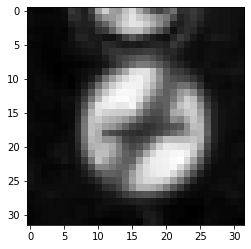

In [0]:
plt.imshow(color.rgb2gray(xTrain[0]), cmap = plt.get_cmap('gray'))

In [0]:
xTrainGray = color.rgb2gray(xTrain).reshape(-1, 32, 32, 1)
xTestGray = color.rgb2gray(xTest).reshape(-1, 32, 32, 1)

In [0]:
model = getCNN_v6((32, 32, 1), numClasses)
modelTrained = trainModel(model, xTrainGray, yTrain, aParamsFit = {})
predict(modelTrained, xTestGray, yTest)

Epoch 1/5
272/272 [==============================] - 7s 25ms/step - loss: 2.4870 - accuracy: 0.3061 - val_loss: 0.5920 - val_accuracy: 0.8092
Epoch 2/5
272/272 [==============================] - 6s 24ms/step - loss: 0.4874 - accuracy: 0.8417 - val_loss: 0.1375 - val_accuracy: 0.9563
Epoch 3/5
272/272 [==============================] - 6s 24ms/step - loss: 0.2286 - accuracy: 0.9271 - val_loss: 0.0614 - val_accuracy: 0.9830
Epoch 4/5
272/272 [==============================] - 6s 24ms/step - loss: 0.1495 - accuracy: 0.9525 - val_loss: 0.0343 - val_accuracy: 0.9902
Epoch 5/5
272/272 [==============================] - 6s 24ms/step - loss: 0.1182 - accuracy: 0.9626 - val_loss: 0.0204 - val_accuracy: 0.9941


0.9682539682539683